In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

/home/cybertech2/tomekg/NLP_learning/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset('emotion')

/home/cybertech2/tomekg/NLP_learning/.venv/lib/python3.8/site-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
model_chkpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_chkpt)
model = AutoModel.from_pretrained(model_chkpt).to('cuda')

In [5]:
def tokenize_batch(batch, tokenizer=tokenizer):
    return tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')

ds = ds.map(tokenize_batch, batched=True, batch_size=None)

In [6]:
print(ds['train'][0])

{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [7]:
ds.set_format('pytorch')

In [8]:
def extract_hidden_states(batch, tokenizer=tokenizer, model=model, device='cuda'):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'last_hidden_state': last_hidden_state[:,0].cpu().numpy()} # cls hidden state

ds = ds.map(extract_hidden_states, batched=True, batch_size=None)

Map: 100%|██████████| 2000/2000 [00:01<00:00, 1431.93 examples/s]


In [9]:
ds['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'last_hidden_state']

In [10]:
X_train = np.array(ds['train']['last_hidden_state'])
y_train = np.array(ds['train']['label'])
X_test = np.array(ds['test']['last_hidden_state'])
y_test = np.array(ds['test']['label'])

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16000, 768), (16000,), (2000, 768), (2000,))

In [12]:
def reduce_dim_umap(X):
    reducer = umap.UMAP(n_components=5)
    X_scaled = StandardScaler().fit_transform(X)
    return reducer.fit_transform(X_scaled)

X_train_reduced = reduce_dim_umap(X_train)

In [13]:
df_train_reduced = pd.DataFrame(
    data=X_train_reduced, 
    columns=[f'component_{n}' for n in range(5)]
    )
df_train_reduced['label'] = ds['train']['label'].tolist()
df_train_reduced.head()

,component_0,component_1,component_2,component_3,component_4,label
0,3.257075,3.247644,5.440238,4.088625,8.136546,0
1,-1.993978,2.870208,9.110153,3.652467,4.519619,0
2,4.843114,4.446162,6.633368,4.543589,8.929282,3
3,-2.191017,3.411515,8.527373,4.636226,5.965617,2
4,-2.577139,3.562199,8.644759,3.863395,5.964476,3


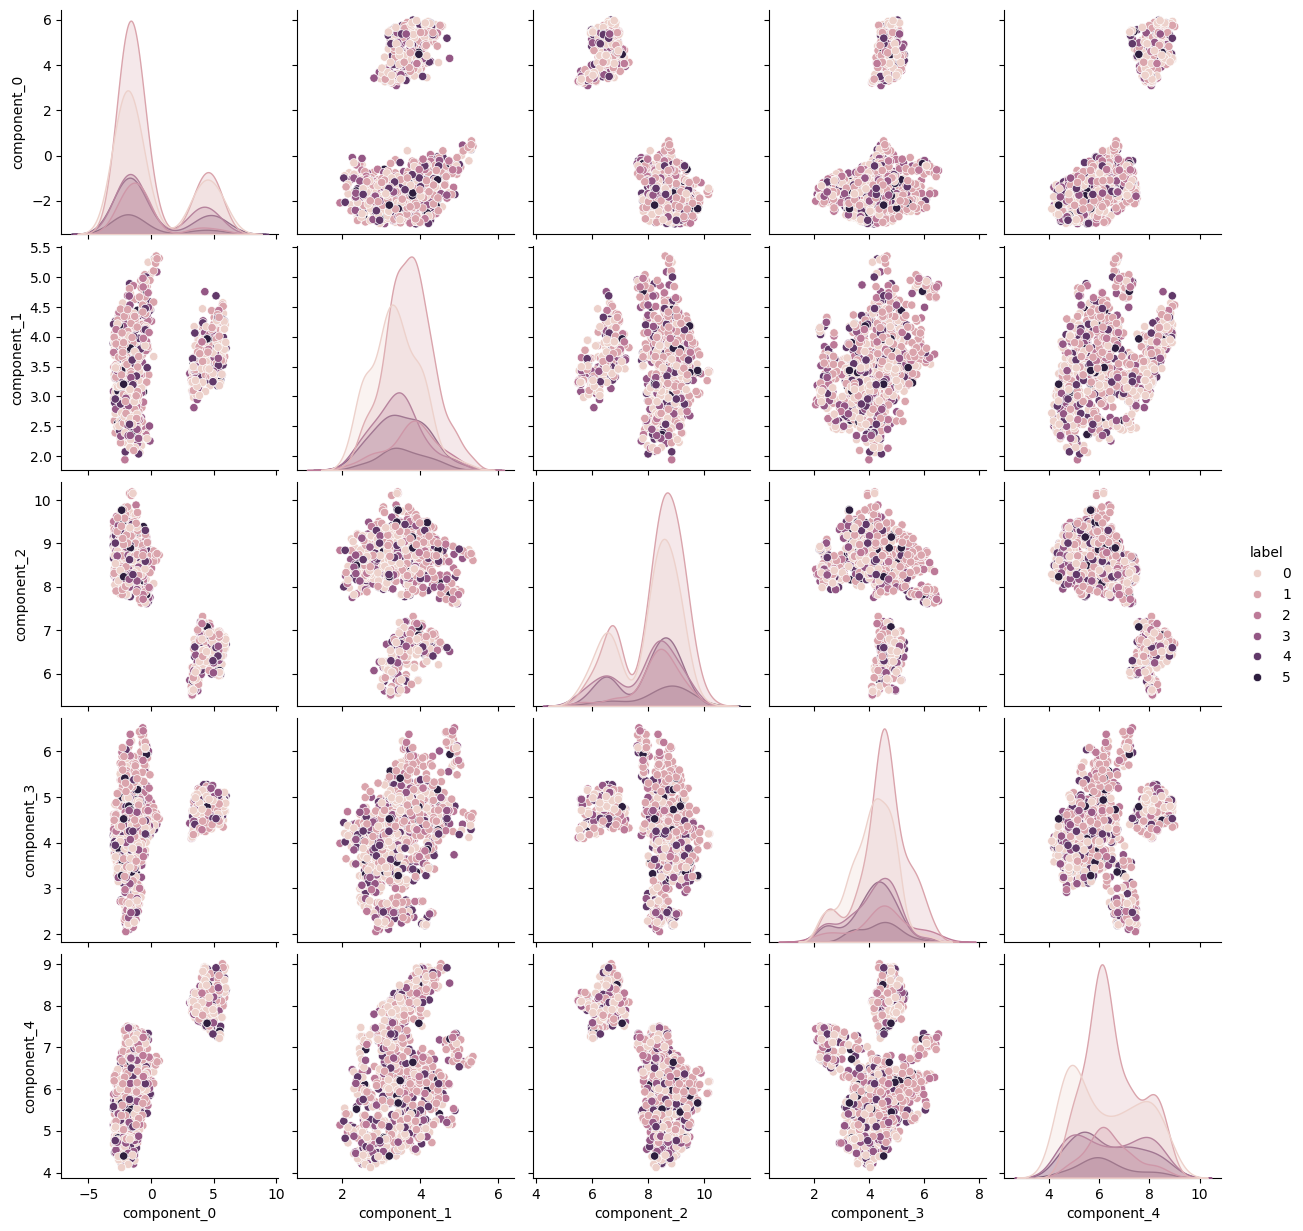

In [15]:
sns.pairplot(df_train_reduced.sample(1000), hue='label')
plt.show()

In [19]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm = np.round(cm, 3)
    _, ax = plt.subplots(figsize=(6, 6))
    ax.set_title("Normalized confusion matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    sns.heatmap(cm, annot=True, ax=ax, cmap="YlGnBu")
    plt.show()

In [20]:
def train_test_simple_clf(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    plot_confusion_matrix(y_test, pred_test)
    return {'f1_macro': f1_score(y_test, pred_test, average='macro'), 
            'f1_micro': f1_score(y_test, pred_test, average='micro'),
            'accuracy': accuracy_score(y_test, pred_test)}

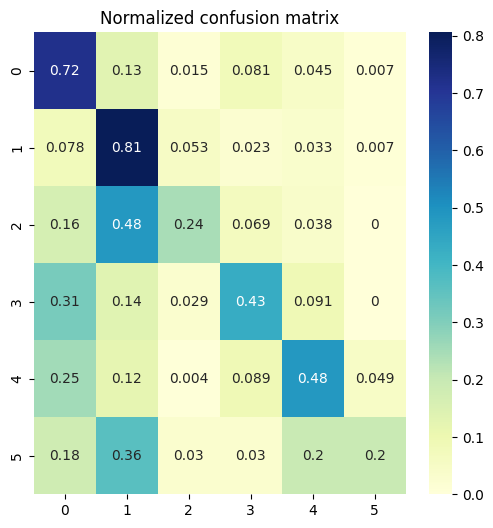

{'f1_macro': 0.49715421664647, 'f1_micro': 0.6275, 'accuracy': 0.6275}

In [21]:
logistic_regression = LogisticRegression(max_iter=3000)
results_logistic_regression = train_test_simple_clf(
    model=logistic_regression,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)
results_logistic_regression

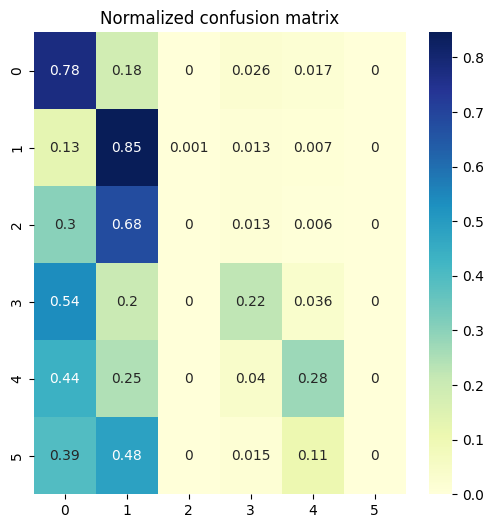

{'f1_macro': 0.3429075862036604, 'f1_micro': 0.5805, 'accuracy': 0.5805}

In [22]:
svm = SVC()
results_svm= train_test_simple_clf(
    model=svm,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)
results_svm